In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, classification_report

In [10]:
# Indonesia heart attack dataframe
df_raw = pd.read_csv("/Users/ty/Library/Mobile Documents/com~apple~CloudDocs/PG/#DSBS/03-Y1S2/STAT5104 Data Mining/05-Project/Dataset/HA.csv")

In [11]:
df = df_raw.copy()

# =================================Data Preprocessing=================================

# Drop rows with missing values
df.dropna(inplace=True)

# Turn all string columns into lower case
df = df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

# =================================Create new columns=================================
# Create a column called "cholesterol_nonhdl" by subtracting "cholesterol_hdl" from "cholesterol_level"
df["cholesterol_nonhdl"] = df["cholesterol_level"] - df["cholesterol_hdl"]

# =================================Rearrange columns=================================
# Insert the column "cholesterol_nonhdl" to the dataframe after "cholesterol_hdl"
df.insert(df.columns.get_loc("cholesterol_hdl") + 1, "cholesterol_nonhdl", df.pop("cholesterol_nonhdl"))
# Move the column "cholesterol_level" to before "cholesterol_hdl"
df.insert(df.columns.get_loc("cholesterol_hdl"), "cholesterol_level", df.pop("cholesterol_level"))


# =================================Drop columns=================================
# Drop hypertension
df.drop(columns=["hypertension", "cholesterol_hdl", "diabetes"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63507 entries, 2 to 158352
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             63507 non-null  int64  
 1   gender                          63507 non-null  object 
 2   region                          63507 non-null  object 
 3   income_level                    63507 non-null  object 
 4   obesity                         63507 non-null  int64  
 5   waist_circumference             63507 non-null  int64  
 6   family_history                  63507 non-null  int64  
 7   smoking_status                  63507 non-null  object 
 8   alcohol_consumption             63507 non-null  object 
 9   physical_activity               63507 non-null  object 
 10  dietary_habits                  63507 non-null  object 
 11  air_pollution_exposure          63507 non-null  object 
 12  stress_level                    6350

Possible interactions:
1. "previous_heart_disease" with ["obesity", "triglycerides", "blood_pressure_systolic", "blood_pressure_diastolic", "fasting_blood_sugar", "cholesterol_level", "cholesterol_nonhdl", "cholesterol_ldl", "EKG_results", "waist_circumference"]
2. "medication_usage" with ["obesity", "alcohol_consumption", "blood_pressure_systolic", "blood_pressure_diastolic", "fasting_blood_sugar", 'cholesterol_level', 'cholesterol_nonhdl', 'cholesterol_ldl', 'triglycerides', "previous_heart_disease"]
3. "fasting_blood_sugar", "obesity", "waist_circumference"
4. "blood_pressure_systolic" and "blood_pressure_diastolic"

In [12]:
# Print the columns of the dataframe
print(df.columns)

Index(['age', 'gender', 'region', 'income_level', 'obesity',
       'waist_circumference', 'family_history', 'smoking_status',
       'alcohol_consumption', 'physical_activity', 'dietary_habits',
       'air_pollution_exposure', 'stress_level', 'sleep_hours',
       'blood_pressure_systolic', 'blood_pressure_diastolic',
       'fasting_blood_sugar', 'cholesterol_level', 'cholesterol_nonhdl',
       'cholesterol_ldl', 'triglycerides', 'EKG_results',
       'previous_heart_disease', 'medication_usage',
       'participated_in_free_screening', 'heart_attack'],
      dtype='object')


<Axes: ylabel='Frequency'>

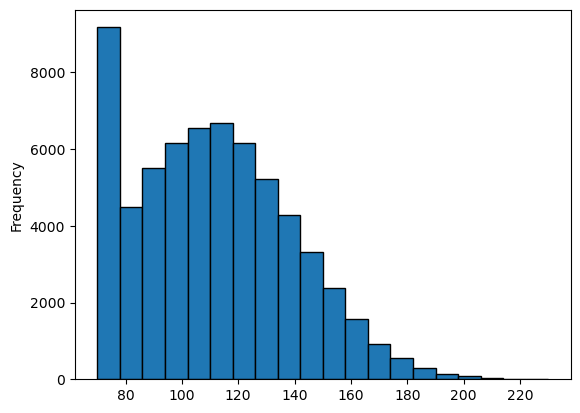

In [13]:
df["fasting_blood_sugar"].plot(kind="hist", bins=20, edgecolor="black")


In [14]:
df["income_level"].value_counts()

income_level
middle    28637
low       25418
high       9452
Name: count, dtype: int64

In [15]:
# ============================Encoding============================

# Turn the variables into categorical variables
df["gender"] = np.where(df["gender"] == "male", 1, 0) 
df["region"] = np.where(df["region"] == "urban", 1, 0) 
df["income_level"] = df["income_level"].map({"low": 0, "middle": 1, "high": 2})
df["smoking_status"] = df["smoking_status"].map({"never": 0, "past": 1, "current": 2})
df['alcohol_consumption'] = df['alcohol_consumption'].map({'moderate': 0, 'high': 1})
df["physical_activity"] = df["physical_activity"].map({"low": 0, "moderate": 1, "high": 2})
df["dietary_habits"] = df["dietary_habits"].map({"unhealthy": 0, "healthy": 1})
df["air_pollution_exposure"] = df["air_pollution_exposure"].map({"low": 0, "moderate": 1, "high": 2})
df["stress_level"] = df["stress_level"].map({"low": 0, "moderate": 1, "high": 2})
df["EKG_results"] = df["EKG_results"].map({"abnormal": 0, "normal": 1})

cols = ["income_level", "smoking_status", "alcohol_consumption", "physical_activity", "dietary_habits", "air_pollution_exposure", "stress_level"]
# Create a dictionary that holds the range/category before encoding
category_dict = {
    "gender": {
        0: "female",
        1: "male"
    },
    "region": {
        0: "rural",
        1: "urban"
    },
    "income_level": {
        0: "low",
        1: "middle",
        2: "high"
    },
    "smoking_status": {
        0: "never",
        1: "past",
        2: "current"
    },
    "alcohol_consumption": {
        0: "moderate",
        1: "high"
    },
    "physical_activity": {
        0: "low", 
        1: "moderate", 
        2: "high"},
    "dietary_habits": {
    0: "unhealthy",
    1: "healthy"
    },
    "air_pollution_exposure": {
    0: "low",
    1: "moderate",
    2: "high"
    },
    "EKG_results": {
    0: "abnormal",
    1: "normal"
    }
}
#df.to_csv("HA_cleaned.csv", index=False)
df

,age,gender,region,income_level,obesity,waist_circumference,family_history,smoking_status,alcohol_consumption,physical_activity,...,fasting_blood_sugar,cholesterol_level,cholesterol_nonhdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
2,62,0,1,0,1,112,1,1,0,1,...,118,231,162,130,171,0,0,1,0,1
3,73,1,1,0,0,82,1,0,0,1,...,98,202,150,85,146,1,0,1,1,0
4,52,1,1,1,0,89,0,2,0,1,...,104,232,173,127,139,1,1,0,1,1
6,73,0,0,0,1,91,0,0,0,1,...,88,238,198,128,167,1,0,1,1,0
7,64,0,1,0,0,72,1,0,1,0,...,112,165,118,100,50,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158339,64,0,0,0,0,77,0,2,0,0,...,138,199,157,81,134,1,0,0,1,1
158340,46,1,1,1,0,96,1,1,0,2,...,139,229,178,174,150,1,0,0,1,0
158342,37,0,1,1,0,91,1,1,1,0,...,79,211,172,108,74,1,0,0,0,0
158343,51,1,1,0,1,101,0,2,0,0,...,121,148,115,170,173,1,0,0,1,1


In [16]:
df_clean = pd.read_csv("HA_cleaned.csv")
df_clean

FileNotFoundError: [Errno 2] No such file or directory: 'HA_cleaned.csv'

In [ ]:
# Split the data into X and y
X = df.drop(columns="heart_attack")
y = df["heart_attack"].values

# Define the random seed
SEED = 42

# Split the data into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=SEED)

In [ ]:
# ======================Function for getting performance metrics=========================
def get_accuracy(tree_input):
    """Get accuracy score of validation and testing data with decision tree as input"""
    
    # Define the tree # type: ignore
    tree = tree_input

    # Fit the model on the training data
    tree.fit(X_train, y_train)

    # Predict the target
    y_pred = tree.predict(X_test)
    y_pred_val = tree.predict(X_val)

    # Calculate the accuracy score for training, validation, and testing data
    accuracy_testing = accuracy_score(y_test, y_pred)
    accuracy_validation = accuracy_score(y_val, y_pred_val)

    return accuracy_validation, accuracy_testing

def get_CV_score(tree_input):
    """Get cross validation score with decision tree as input"""
    
    # Define the tree
    tree = tree_input

    # Split the data using KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # Cross validation
    cv_score = cross_val_score(tree, X, y, cv=kf)
    
    # print(f"Mean cross validation score: {cv_score.mean()}")
    return cv_score

def get_metrics(tree_input):
    """Print the accuracy score and cross validation score of the decision tree"""

    print(f"Accuracy in validation data: {get_accuracy(tree_input)[0]}")
    print(f"Accuracy in testing data: {get_accuracy(tree_input)[1]}")
    print(f"Mean cross validation score: {get_CV_score(tree_input).mean()}")
    # print(f"Precision score: {precision_score(y_test, tree_input.predict(X_test), average="macro", zero_division=0)}")
    print(f"Precision score: {precision_score(y_test, tree_input.predict(X_test), average='macro', zero_division=0)}")
    # print(f"Recall score: {recall_score(y_test, tree_input.predict(X_test), average="macro")}")
    print(f"Recall score: {recall_score(y_test, tree_input.predict(X_test), average='macro')}")
    # print(f"F1 score: {f1_score(y_test, tree_input.predict(X_test), average="macro")}")
    # print(f"Classification report: \n{classification_report(y_test, tree_input.predict(X_test))}")
    print(f"F1 score: {f1_score(y_test, tree_input.predict(X_test), average='macro')}")
    print(f"Classification report: \n{classification_report(y_test, tree_input.predict(X_test))}")

# ===================Function for tuning the Decision Tree ===================
def get_opt_tree():
    """Get the optimal Decision Tree Classifier"""

    def get_hyperparameter():
        """Get the optimal hyperparameters for Decision Tree Classifier"""
        # Initialize a new Decision Tree Classifier
        new_dt = DecisionTreeClassifier(random_state=SEED)

        # Define the hyperparameter grid
        param_grid = {
            'max_depth': range(2, 20, 2),
            'min_samples_leaf': range(10, 3000, 10),
            'min_samples_split': range(10, 3000, 10),
            'criterion': ["gini", "entropy", "log_loss"]
        }

        # Perform a randomized search to find the optimal hyperparameters
        random_search = RandomizedSearchCV(
            estimator=new_dt, 
            param_distributions=param_grid, 
            cv=5, 
            n_iter=10, 
            n_jobs=-1, 
            random_state=SEED)
        random_search.fit(X, y)

        # Print the optimal hyperparameters
        print("Optimal hyperparameters:", random_search.best_params_)

        # Print the best score
        print("Best score with optimal hyperparameters:", random_search.best_score_)

        return random_search.best_params_
    
    # Initialize the tree with the optimal hyperparameters: opt_tree
    optimized_tree = DecisionTreeClassifier(
        **get_hyperparameter(), 
        random_state=SEED
    )

    return optimized_tree

# ===================Function for tuning with Bagging ===================
def get_opt_bc(tree_input):
    """Get the optimal Bagging Classifier"""
    
    # Define the tree
    tree = tree_input

    # Define the hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_samples': [0.5, 0.75, 1.0],
        'max_features': [0.5, 0.75, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False]
    }

    # Initialize a new Bagging Classifier
    bc = BaggingClassifier(
        estimator=tree, 
        n_jobs=-1,
        oob_score=True,
        random_state=SEED
    )

    # Perform a randomized search to find the optimal hyperparameters
    random_search = RandomizedSearchCV(bc, param_distributions=param_grid, cv=5, n_iter=10, n_jobs=-1, random_state=SEED)
    random_search.fit(X_train, y_train)

    # Get the optimal Bagging Classifier
    opt_bc = random_search.best_estimator_

    return opt_bc

# ===================Function for tuning with Random Forest ===================
def get_opt_rf(n_estimators=300):
    """Get the optimal Random Forest Classifier"""

    # Initialize a new Random Forest Classifier
    rf = RandomForestClassifier(
        n_jobs=-1,
        random_state=SEED
    )

    # Define the hyperparameter grid
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 5, 10],
        'max_features': ['auto', 'sqrt', 'log2']
    }

    # Perform a randomized search to find the optimal hyperparameters
    random_search = RandomizedSearchCV(rf, param_distributions=param_grid, cv=5, n_iter=10, n_jobs=-1, random_state=SEED)
    random_search.fit(X_train, y_train)

    # Get the optimal Random Forest Classifier
    opt_rf = random_search.best_estimator_

    return opt_rf


In [ ]:
# Initialize a Decision Tree Classifier without hyperparameter with Gini as criterion
dt = DecisionTreeClassifier(random_state=SEED)

# Initialize a Decision Tree Classifier without hyperparameter with Entropy as criterion
dt_entropy = DecisionTreeClassifier(criterion="entropy", random_state=SEED)

# Initialize a Decision Tree Classifier without  hyperparameters with log_loss as criterion
dt_log_loss = DecisionTreeClassifier(criterion="log_loss", random_state=SEED)

In [ ]:
# Define the decision trees
trees = [dt, dt_entropy, dt_log_loss]
criteria = ["Gini", "Entropy", "Log Loss"]

# Print the metrics
for tree, criterion in zip(trees, criteria):
    print(f"\nAccuracy performance of Decision Tree with {criterion} as criterion:")
    get_metrics(tree)
    
# ==================================Original=================================
# # Print the metrics of the Decision Trees with Gini, Entropy and log loss as criterion
# print(f"\nAccuracy performance of Decision Tree with Gini as criterion:")
# get_metrics(dt)
# print(f"\nAccuracy performance of Decision Tree with Entropy as criterion:")
# get_metrics(dt_entropy)
# print(f"\nAccuracy performance of Decision Tree with Log Loss as criterion:")
# get_metrics(dt_log_loss)


In [ ]:
# Define the decision trees
trees = [dt, dt_entropy, dt_log_loss]
criteria = ["Gini", "Entropy", "Log Loss"]

# Print the confusion matrices
for tree, criterion in zip(trees, criteria):
    confusion_mtx = confusion_matrix(y_test, tree.predict(X_test))
    print(f"\nConfusion matrix with {criterion} as criterion:\n{confusion_mtx}")

# ==================================Original=================================
# # Return the confusion matrix when using Gini as criterion
# confusion_mtx_gini = confusion_matrix(y_test, dt.predict(X_test))
# print(f"\nConfusion matrix with Gini as criterion:\n{confusion_mtx_gini}")

# # Return the confusion matrix when using Entropy as criterion
# confusion_mtx_entropy = confusion_matrix(y_test, dt_entropy.predict(X_test))
# print(f"\nConfusion matrix with Entropy as criterion:\n{confusion_mtx_entropy}")

# # Return the confusion matrix when using Log Loss as criterion
# confusion_mtx_log_loss = confusion_matrix(y_test, dt_log_loss.predict(X_test))
# print(f"\nConfusion matrix with Log Loss as criterion:\n{confusion_mtx_log_loss}")

In [ ]:
# Get the optimal Decision Tree Classifier
opt_tree = get_opt_tree()

# Get the accuracy score and CV score of the optimal Decision Tree Classifier
print(f"\nAccuracy performance of the optimal Decision Tree:")
get_metrics(opt_tree)

In [ ]:
# Train the Decision Tree
opt_tree_train = opt_tree.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(
    opt_tree_train, filled=True, feature_names=df.drop(columns="heart_attack").columns)
plt.show()

In [ ]:
# Get the optimal Bagging Classifiers
bc_opt_tree = get_opt_bc(opt_tree)
bc_default = get_opt_bc(dt)
bc_entropy = get_opt_bc(dt_entropy)
bc_log_loss = get_opt_bc(dt_log_loss)

# Evaluate the performance of each Bagging Classifier
classifiers = [bc_opt_tree, bc_default, bc_entropy, bc_log_loss]
labels = ["Optimized Tree", "Default Tree", "Entropy Tree", "Log Loss Tree"]

for bc, label in zip(classifiers, labels):
    print(f"\nAccuracy performance of Bagging Classifier with {label}:")
    get_metrics(bc)
    print(f"Out of bag score: {bc.oob_score_}")

# ==================================Original=================================
# # Get the optimal Bagging Classifier with optimized tree
# bc_opt_tree = get_opt_bc(opt_tree)
# # Get the optimal Bagging Classifier with default tree
# bc = get_opt_bc(dt)
# # Get the optimal Bagging Classifier with Entropy tree
# bc_entropy = get_opt_bc(dt_entropy)
# # Get the optimal Bagging Classifier with Log Loss tree
# bc_log_loss = get_opt_bc(dt_log_loss)

# # Get the performance and out of bag score with optimized tree
# print(f"\nAccuracy performance of Bagging Classifier with optimized tree:")
# get_metrics(bc_opt_tree)
# print(f"Out of bag score: {bc_opt_tree.oob_score_}")
# # Get the perforamnce and out of bag score with default tree
# print(f"\nAccuracy performance of optimal Bagging Classifier:")
# get_metrics(bc)
# print(f"Out of bag score: {bc.oob_score_}")
# # Get the perforamnce and out of bag score with entropy tree
# print(f"\nAccuracy performance of optimal Bagging Classifier with Entropy tree:")
# get_metrics(bc_entropy)
# print(f"Out of bag score: {bc_entropy.oob_score_}")
# # Get the perforamnce and out of bag score with log loss tree
# print(f"\nAccuracy performance of optimal Bagging Classifier with Log Loss tree:")
# get_metrics(bc_log_loss)
# print(f"Out of bag score: {bc_log_loss.oob_score_}")

In [ ]:
# # Return the confusion matrix when using Bagging
# confusion_mtx_bc = confusion_matrix(y_test, bc_opt_tree.predict(X_test))
# print(f"\nConfusion matrix with Bagging:\n{confusion_mtx_bc}")

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': range(10, 160, 10),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

# Perform a randomized search to find the optimal hyperparameters
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=SEED), param_distributions=param_grid, cv=5, n_iter=10, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Get the optimal Random Forest Classifier
opt_rf = random_search.best_estimator_

# Get the accuracy score and CV score of the optimal Random Forest Classifier
print(f"\nAccuracy performance of the optimal Random Forest:")
get_metrics(opt_rf)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

# scores =[]
# for i in range(10, 160, 10):
#     # Get the optimal Random Forest Classifier
#     opt_rf = get_opt_rf(i)

#     # Get the accuracy score and CV score of the optimal Random Forest Classifier
#     print(f"\nAccuracy performance of the optimal Random Forest:")
#     get_metrics(opt_rf)
#     scores.append(f1_score(y_test, opt_rf.predict(X_test), average="macro"))

# print(f"\nMax F1 score: {range(100, 1100, 100)[np.max(scores).argmax()]}, {np.max(scores)}")

In [ ]:
# Print the important features
importances = pd.Series(data=opt_rf.feature_importances_,
                        index= X_train.columns)[:20]
# Sort importances
importances_sorted = importances.sort_values(ascending=True)

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(10, 12))
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()